I initially had a hard time understanding the tensor dimensions defining the conv layers in PyTorch. I went through several different variatios of architectures before I got one that made sense to me. I also had some issues with getting the tensor dimensions of the residual connections correct.

# Task 1

Number of samples: 50000
Image shape: (32, 32)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label: 6 (frog)


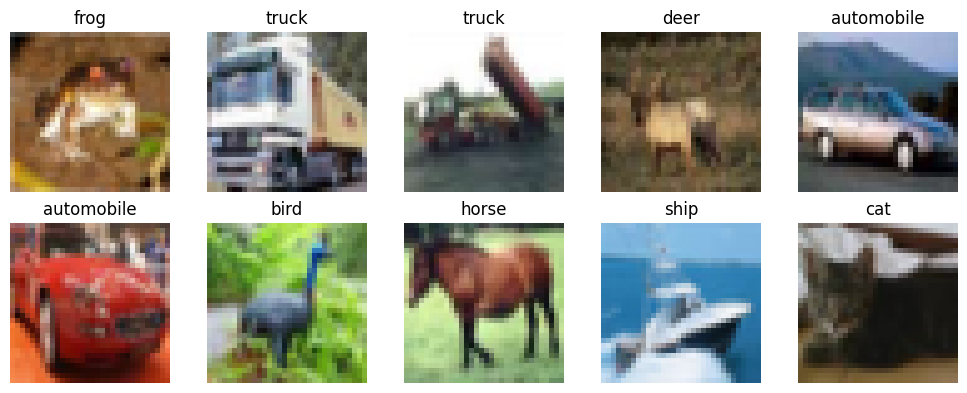

In [55]:
import torchvision
# torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

import matplotlib.pyplot as plt

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

# Basic info
print(f"Number of samples: {len(trainset)}")
print(f"Image shape: {trainset[0][0].size}")  # PIL Image size (width, height)
print(f"Number of classes: {len(trainset.classes)}")
print(f"Classes: {trainset.classes}")

# Look at a single sample
image, label = trainset[0]
print(f"Label: {label} ({trainset.classes[label]})")

# Display some images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, lbl = trainset[i]
    ax.imshow(img)
    ax.set_title(trainset.classes[lbl])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN_task1(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 32 -> 16
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # Block 2: 16 -> 8
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Block 3: 8 -> 4
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Print parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        # Block 1: 32 -> 16
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool(x)
        
        # Block 2: 16 -> 8
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool(x)
        
        # Block 3: 8 -> 4
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Pad by 4, then crop back to 32x32
    transforms.RandomHorizontalFlip(),      # 50% chance to flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train samples: {len(trainset)}, Test samples: {len(testset)}")

Train samples: 50000, Test samples: 10000


In [ ]:
from tqdm import tqdm
from IPython.display import display, clear_output

def train(model, num_epochs=10, lr=1e-3):
    """Train a model on CIFAR-10."""
    # Move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on: {device}")
    
    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track losses for plotting
    step_losses = []
    
    # Setup live plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    step = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track stats
            step_losses.append(loss.item())
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            step += 1
            
            # Update plot every 50 steps
            if step % 50 == 0:
                clear_output(wait=True)
                ax.clear()
                ax.plot(step_losses)
                ax.set_xlabel('Step')
                ax.set_ylabel('Loss')
                ax.set_title(f'Training Loss (Epoch {epoch+1}/{num_epochs})')
                ax.grid(True)
                display(fig)
        
        print(f"Epoch {epoch+1} complete - Loss: {running_loss/len(trainloader):.4f}, Acc: {100.*correct/total:.2f}%")
    
    plt.close(fig)
    
    return model

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate(model):
    """Evaluate model on test set."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    correct = 0
    total = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = 100. * correct / total
    avg_loss = running_loss / len(testloader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    
    # Confusion matrix
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return avg_loss, test_acc

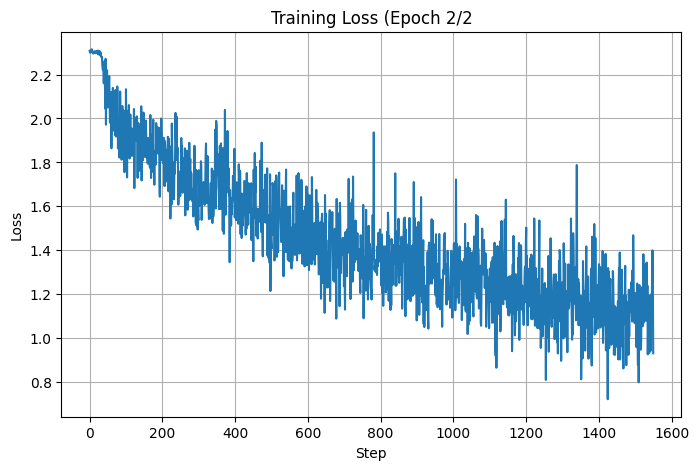

Epoch 2 complete - Loss: 1.2246, Acc: 55.44%


Evaluating: 100%|██████████| 157/157 [00:05<00:00, 30.16it/s]


Test Loss: 1.0916, Test Accuracy: 60.86%


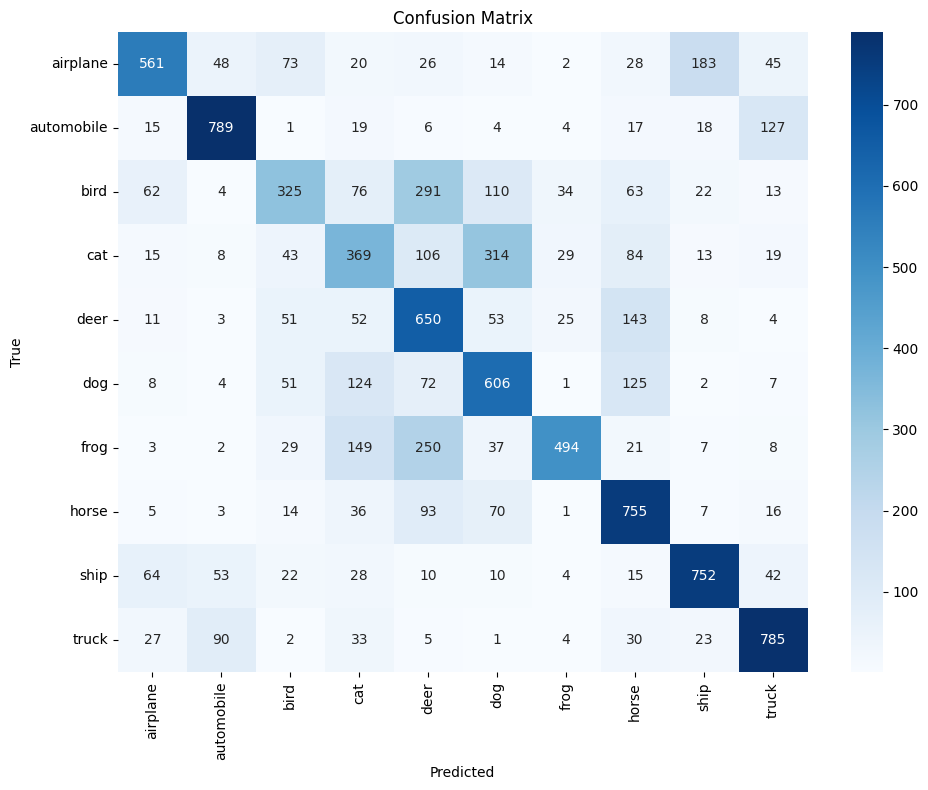

(1.0916446139858027, 60.86)

In [60]:
# Train the model
model = CNN_task1()
model = train(model, num_epochs=2)
evaluate(model)

# Task 2

In [61]:
class CNN_task2(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        self.conv1a = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.shortcut1 = nn.Conv2d(3, 32, kernel_size=1)  # projection (3 -> 32)
        
        # Block 2
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.shortcut2 = nn.Conv2d(32, 64, kernel_size=1)  # projection (32 -> 64)
        
        # Block 3
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.shortcut3 = nn.Conv2d(64, 128, kernel_size=1)  # projection (64 -> 128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Print parameter count
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def forward(self, x):
        # Block 1: projection shortcut (3 -> 32)
        identity = self.shortcut1(x)
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Block 2: projection shortcut (32 -> 64)
        identity = self.shortcut2(x)
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Block 3: projection shortcut (64 -> 128)
        identity = self.shortcut3(x)
        x = F.relu(self.conv3a(x))
        x = self.conv3b(x)
        x = F.relu(x + identity)
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

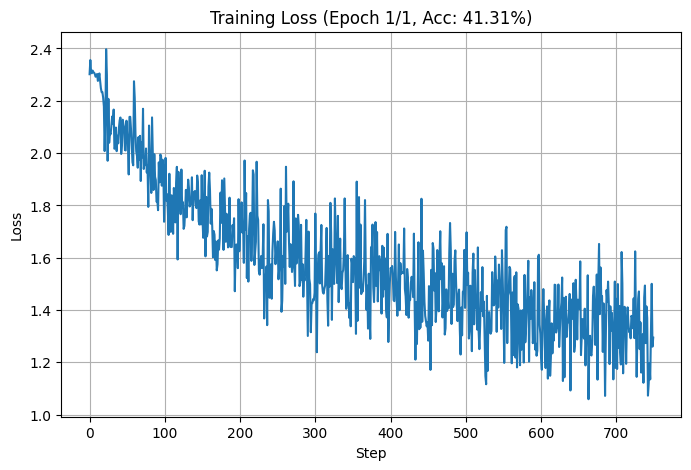

Epoch 1 complete - Loss: 1.5733, Acc: 41.80%


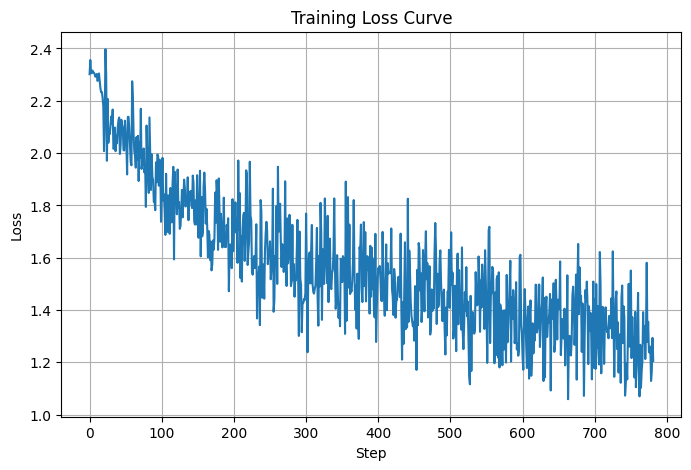

Evaluating: 100%|██████████| 157/157 [00:06<00:00, 25.42it/s]


Test Loss: 1.1950, Test Accuracy: 56.53%


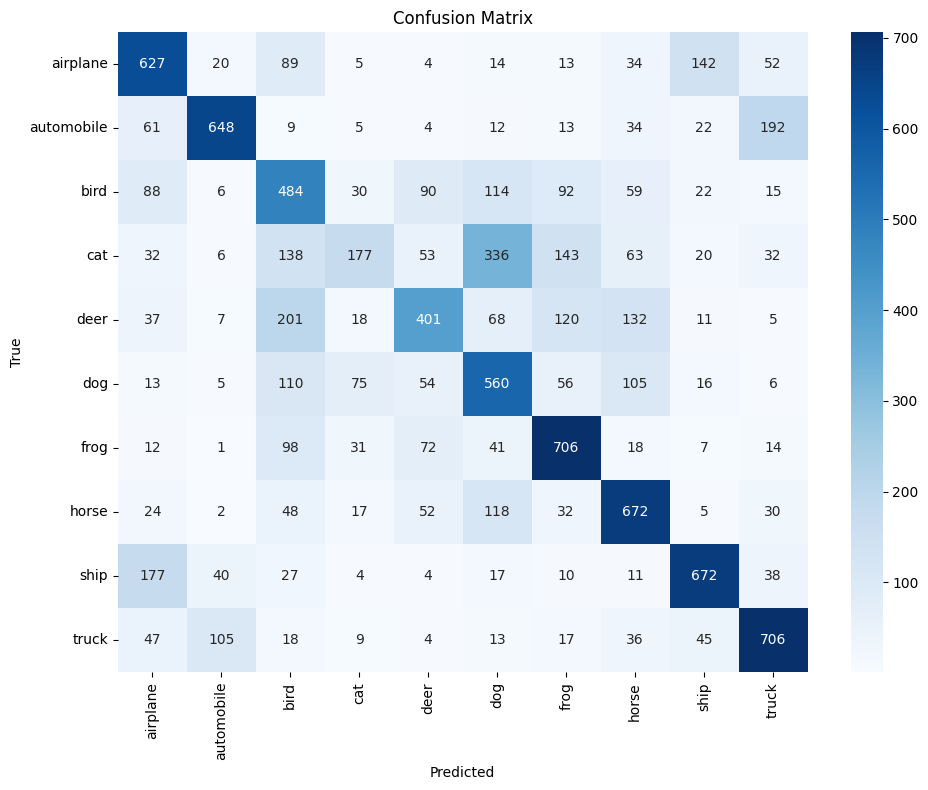

(1.1950287807519269, 56.53)

In [54]:
model_2 = CNN_task2()
model_2 = train(model_2, num_epochs=1)
evaluate(model_2)